# Makie

First impressions:

* The [Figure](https://makie.juliaplots.org/stable/documentation/figure/index.html#figures) object: Plots are created by initializing a Figure object (either explicitly or implicitly with a plotting function call like `lines`)
    * Like the size of the canvas
    * Example: `f = Figure(resolution = (600, 400))`
* Attributes
    * What makes `Makie` so verbose is the fact that there are so many possible attributes that you can modify and set to customize the heck out of your chart. 
    * The Makie docs have the in depth list of all the attributes that you can tweak for [plotting functions](https://makie.juliaplots.org/stable/examples/plotting_functions/) and everything else.
* Layouts
    * Makie supports some complex layouts - with your Figure object you can add subplots by adding axes
* [`Layoutables`](https://makie.juliaplots.org/stable/documentation/layoutables/)
    * Axes and Legends are examples of `Layoutables` - what they call stuff that you can add to the Layout. 
* Observables
    * Special workflow for interactive visualizations
    * An `Observable` is an object that a `Listener` (usually a function) will react to whenever the `Observable` changes

Overall, the workflow feels like `matplotlib` or base `plotly` in that you're creating a canvas with your `Figure` and then adding components with `Plotting Functions` or stuff like `Axes` and `Legend`s to that `Figure` incrementally. Each component has a bunch of attributes that you can fiddle around with and tweak to get the customized visualization that you want. 

In [1]:
using CairoMakie
using DataFramesMeta
using AlgebraOfGraphics, PalmerPenguins

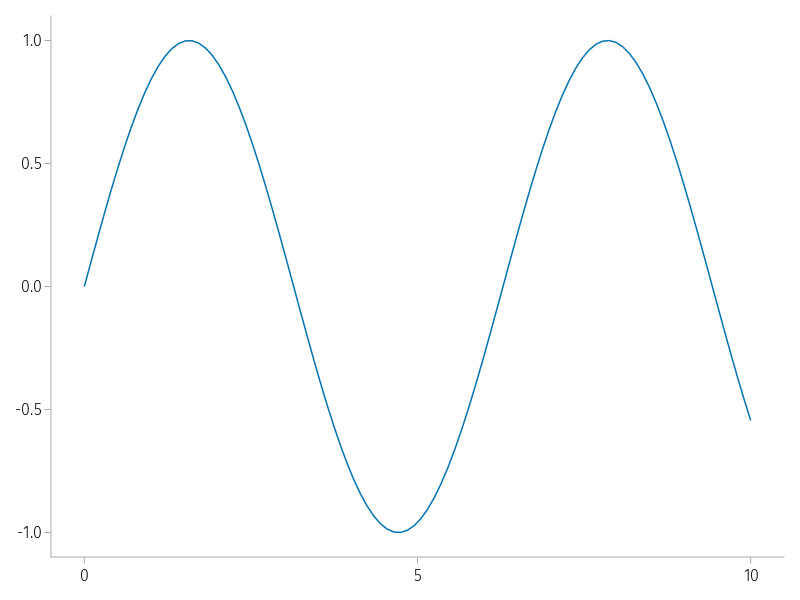

In [119]:
x = range(0, 10, length=100)
y = sin.(x)
lines(x, y)

The `lines` call can be unpacked into a figure, axis, and pltobject separately if you want to attach attributes:

In [123]:
f, ax, pltobject = lines(x, y)
pltobject.attributes

Attributes with 18 entries:
  color => RGB{Float64}(0.0,0.447059,0.698039)
  colormap => batlow
  cycle => [:color]
  depth_shift => 0.0
  diffuse => Float32[0.4, 0.4, 0.4]
  fxaa => false
  inspectable => true
  linestyle => nothing
  linewidth => 1.5
  model => Float32[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
  nan_color => RGBA{Float32}(0.0,0.0,0.0,0.0)
  overdraw => false
  shininess => 32.0
  specular => Float32[0.2, 0.2, 0.2]
  ssao => false
  transformation => Automatic()
  transparency => false
  visible => true

Mutating plot functions allow you to add to an existing figure:

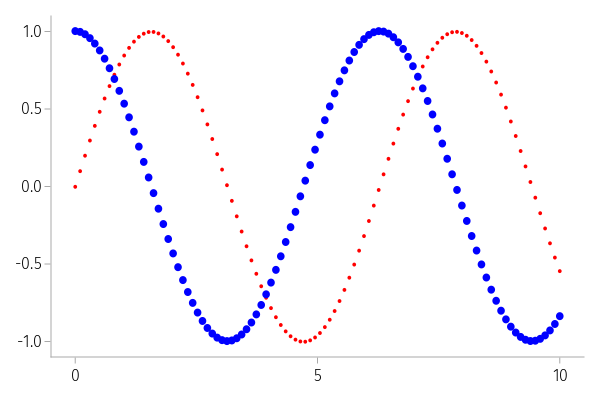

In [106]:
x = range(0, 10, length=100)
y1 = sin.(x)
y2 = cos.(x)
f = Figure(resolution=(600,400))
ax = f[1,1]

scatter(ax, x, y1, color = :red, markersize = 5)
scatter!(ax, x, y2, color = :blue, markersize = 10)
current_figure()

In fact, you can specify pretty much anything within the plot creation function:


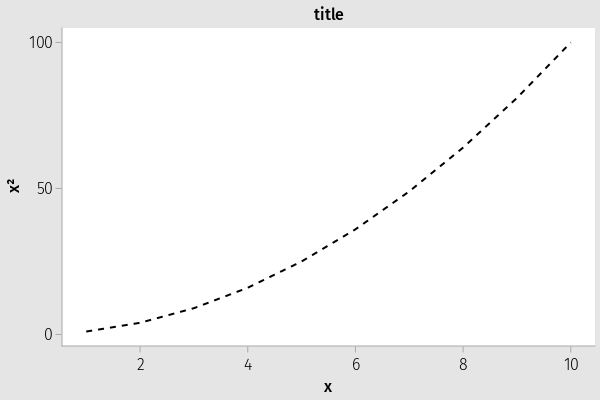

In [79]:
lines(1:10, (1:10).^2; color=:black, linewidth=2, linestyle=:dash,
    figure=(; figure_padding=5, resolution=(600, 400), font="sans",
        backgroundcolor=:grey90, fontsize=16),
    axis=(; xlabel="x", ylabel="x²", title="title",
        xgridstyle=:dash, ygridstyle=:dash))
current_figure()

`Makie` can take a matrix object as well, so imagine we want to create multiple lines all at once with a matrix:


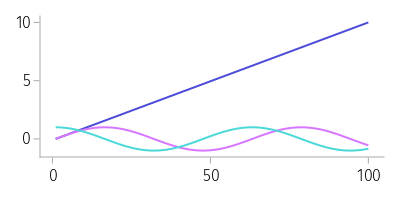

In [151]:
x = range(0, 10, length=100)
y1 = sin.(x)
y2 = cos.(x)

dat = hcat(x,y1,y2)

series(dat', labels=["x", "y1", "y2"], figure=(; resolution=(400,200)))

`Makie` looks for an x and y explicitly or a matrix, so if we were to try to do EDA on a `DataFrame` we would have to write a lot of extra throwaway code while we look through the data. That's where we look for an extension like `AlgebraOfGraphics` for convenience during this initial exploration. 

# AlgebraOfGraphics

While `Makie` is powerful, it does look a little verbose for if you work with tabular data in `DataFrames`. It's recommended if you want to build complex or 'publication quality' plots or you want interactivity, but it could use a wrapper to make things easier for common tasks as a daily driver for data analysis. 

`ggplot2` is still the go-to plotting library for R, and using it within the tidyverse feels like a well thought out, integrated system that is both easy to use and easy to layer complexity on top of it. 

`Gadfly` follows very closely in the `ggplot2` Grammar of Graphics style, so it already feels familiar (dare I say pleasing) to use with `DataFramesMeta` and comes with plenty of customization right out of the bat.

What makes the GoG-style plotting libraries feel so powerful is that you can add or remove layers of complexity on top of the plot without having to type a lot of code. It's flexible in that the core building blocks work together so seamlessly.

Enter `AlgebraOfGraphics`. `AlgebraOfGraphics` uses `Makie` in the background so that you still have all of the options with layouts and attributes, but it allows you to write similarly expressive statements that give you some of the benefits of GoG. However, it's just different enough that it takes some getting used to.

We can start with an example and you can see the code in action:

In [ ]:
# on the first run, if it asks for stdin type in 'y' and hit enter to download
penguins = dropmissing(DataFrame(PalmerPenguins.load()))
first(penguins, 6)

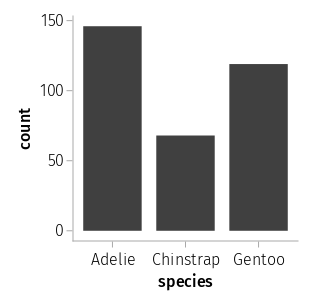

In [108]:
set_aog_theme!() # just like seaborn's sns.set()

axis = (width = 225, height = 225)
penguin_frequency = data(penguins) * frequency() * mapping(:species)

draw(penguin_frequency; axis)

The line:

```julia
penguin_frequency = data(penguins) * frequency() * mapping(:species) 
```

is an example of the *Algebra of Layers*, where Layers are the key building block or abstraction. Each layer is a product of a combination of elementary objects:

* Data
* Mapping: associate data to plot attributes
* Visual: plotting functions from Makie
* Analyses: i.e. Histogram, frequency table

And finally, once you've specified the Layers you use the `draw` function to render it:

```julia
draw(penguin_frequency) # renders the Layers
```

Let's revisit our first `lines` plot from `Makie` using this AoG language:

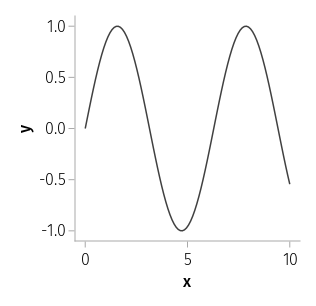

In [170]:
df = DataFrame(x = range(0, 10, length=100), y = sin.(x))
plt = data(df) * mapping(:x, :y) 
draw(plt * visual(Lines); axis)

The multiplication operator (\*) is being used to add objects within the same layer, while the addition operator (+) is used to combine more than one `Layer` into a list of `Layers`. 

The `draw` function operates on either `Layer` or `Layers` and assigns it to the specified figure or axis

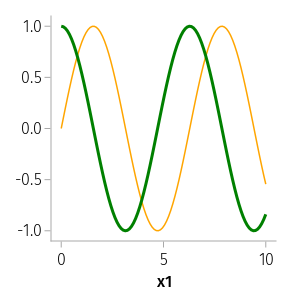

In [195]:
df = DataFrame(dat, :auto)
x2 = data(df) * mapping(:x1, :x2) * visual(Lines, color="orange")
x3 = data(df) * mapping(:x1, :x3) * visual(Lines, color="green", linewidth=3)
# Use the addition operator to combine our two Layer(s)
draw(x2 + x3; axis)